In [1]:
import torch
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import random
from matplotlib.patches import Rectangle
import tifffile
from torch.utils.data import DataLoader

import importlib as imp
import sys
sys.path.append('/home/abenneck/Desktop/yolo_tiles/docs/scripts')

import yolo_tiles
imp.reload(yolo_tiles)
from yolo_tiles import img_to_tiles, apply_model_to_tiles, load_test_image, preprocess, tileDataset, remove_bbox_in_overlap

import yolo_help
imp.reload(yolo_help)
from yolo_help import bbox_to_rectangles, imshow, convert_data, Net, get_best_bounding_box_per_cell

import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import remove_low_conf_bboxes, postprocess, bb_to_rec

## Load a pretrained model and apply it to a test image

In [3]:
# Load and extract tiles from a simulated image
# img, ncell = load_test_image(500,500)
# padded_img, tiles = img_to_tiles(img)

# Load and extract tiles from a real image
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)

# Apply model to tiles + apply bbox edge filtering
outdir_model = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
modelname = 'modelsave.pt'
model_path = os.path.join(outdir_model,modelname)
out_original = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

Finished tiles 100:200/1496 in 6.06s
Finished tiles 400:500/1496 in 25.43s
Finished tiles 500:600/1496 in 10.20s
Finished tiles 600:700/1496 in 10.62s
Finished tiles 700:800/1496 in 9.96s
Finished tiles 800:900/1496 in 10.67s
Finished tiles 900:1000/1496 in 10.41s
Finished tiles 1100:1200/1496 in 18.30s
Finished tiles 1200:1300/1496 in 7.67s
Finished applying model to entire image in 112.34s with 920/1496 (0.6149732620320856:.3f) tiles marked as foreground


### Apply postprocessing + Plot model output

In [7]:
# start0 = time.time()
# net = Net()
# B = net.B
# stride = net.stride
# pads = (np.array(padded_img.shape) - np.array(img.shape))/2
# out_ = postprocess(out, B, stride, pads)
# print(f'Finished postprocessing in {time.time()-start0:.2f}s')

Finished entire image in 102.14s


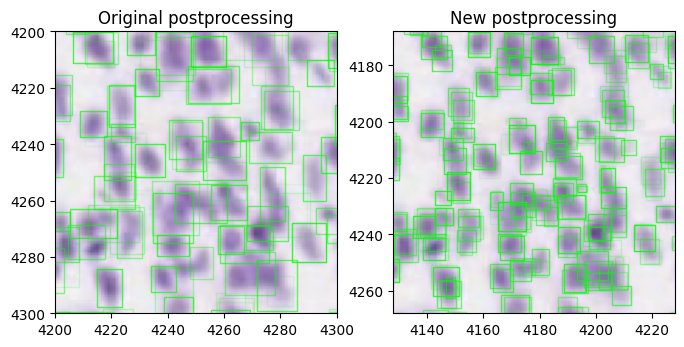

In [6]:
start = time.time()

net = Net()
B = net.B
stride = net.stride

fig, axs = plt.subplots(1,2)

# Display the model results after the OLD workflow
img = plt.imread('/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg')
padded_img, tiles = img_to_tiles(img, upper_threshold_bg = 210)

axs[0].imshow(padded_img)
bboxes, data = convert_data(out_original[None], B, stride)
scores =  torch.Tensor(data[:,-1])
bboxes, scores = get_best_bounding_box_per_cell(bboxes, scores, B)
predicted_rectangles = bbox_to_rectangles(np.asarray(bboxes),fc='none',ec='lime',alpha=scores)
axs[0].add_collection(predicted_rectangles)
axs[0].set_title('Original postprocessing')
axs[0].set_xlim([4200,4300])
axs[0].set_ylim([4300,4200])

# Display the model results after the NEW workflow
img_path = '/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg'
out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
out = np.load(out_path)
out = out.transpose((1,2,0))
# axs[1].imshow(padded_img)
pads = (np.array(padded_img.shape) - np.array(img.shape))/2
axs[1].imshow(img)
scores = out[:,:,4].ravel()
predicted_rectangles = bb_to_rec(out, fc='none', ec='lime', alpha=scores)
axs[1].add_collection(predicted_rectangles)
axs[1].set_title('New postprocessing')
axs[1].set_xlim([4200-pads[1], 4300-pads[1]])
axs[1].set_ylim([4300-pads[0], 4200-pads[0]])

fig.set_size_inches((8,4))

print(f'Finished entire image in {time.time()-start:.2f}s')

In [69]:
print(f'Old bb count {len(bboxes)} vs New bb count {len(scores)}')

Old bb count 1181616 vs New bb count 4618656


# Real Data Processing

In [2]:
model_path = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_saved_weights/modelsave_bright_on_dark.pt'
# model_path = '/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854/modelsave.pt'
net = Net()
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [3]:
# Load a target image
start_total = time.time()
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
outdir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v04/'
next_idx = 3202

net = Net()
B = net.B
stride = net.stride

for idx, fname in enumerate(sorted(os.listdir(img_dir))):

    if idx < next_idx:
        continue

    # Load input image
    img_path = os.path.join(img_dir, fname)
    img = tifffile.imread(img_path)

    # img_path = '/home/abenneck/Desktop/yolo_model/images/section_000197_30800.jpeg'
    # img = plt.imread(img_path)
    # img = np.transpose(img, (2,0,1))
    # img = img[0]
    
    # Preprocess using gamma correction + upsampling
    start = time.time()
    img_up = preprocess(img)
    print(f'Finished preprocessing in {time.time()-start:.2f}s')
    
    # Extract tiles from the preprocessed input image
    padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)
    
    # Apply model to tiles + apply bbox edge filtering
    print('Applying model to tiles . . .')
    out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

    # Convert the raw model output into a more useful data structure
    print('Postprocessing . . .')
    pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
    out = torch.tensor(out.clone().detach(), dtype=torch.float32)
    out = postprocess(out, B, stride, pads, up_factor=2, verbose=True)

    # Save the processed output
    out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
    out_path = os.path.join(outdir, out_fname)
    np.save(out_path, out)

    # (11/19/25) Save some additional metadata in an npz file
    out_fnamez = (img_path.split('/')[-1]).split('.')[0] + '_metadata.npz'
    out_pathz = os.path.join(outdir, out_fnamez)
    np.savez(out_pathz,
            units = 'um',
            nrow_orig_img = img.shape[0],
            ncol_orig_img = img.shape[1],
            drow_orig_img = 1.866,
            dcol_orig_img = 1.866,
            dslice_orig_img = 2.0,
            nrow_upsampled_img = img_up.shape[0],
            ncol_upsampled_img = img_up.shape[1], 
            drow_upsampled_img = 3.732,
            dcol_upsampled_img = 3.732,
            pad_row_top = pads[0],
            pad_row_bot = pads[0],
            pad_col_left = pads[1],
            pad_col_right = pads[1],
            nrow = out.shape[0],
            ncol = out.shape[1],
            drow = 7.464,
            dcol = 7.464,
            note = "Bbox coords refer to the original image, with (0,0) corresponding to the top left pixel center"
            )    
    
    print(f'Saved the outputs for image {idx}/{len(os.listdir(img_dir))} in {time.time()-start_total:.2f}s\n')
    start_total = time.time()


Finished preprocessing in 2.47s
Finished extracting all tiles in 6.80s
Applying model to tiles . . .
Finished tiles 0:100/5082 in 0.29s
Finished tiles 100:300/5082 in 0.77s
Finished tiles 300:500/5082 in 0.83s
Finished tiles 500:700/5082 in 0.99s
Finished tiles 700:1900/5082 in 4.61s
Finished tiles 1900:2000/5082 in 0.47s
Finished tiles 2000:2100/5082 in 0.88s
Finished tiles 2100:2200/5082 in 0.98s
Finished tiles 2200:2400/5082 in 2.30s
Finished tiles 2400:2600/5082 in 2.32s
Finished tiles 2600:2800/5082 in 2.20s
Finished tiles 2800:3000/5082 in 2.18s
Finished tiles 3000:3200/5082 in 2.01s
Finished tiles 3200:3400/5082 in 1.75s
Finished tiles 3400:3600/5082 in 1.54s
Finished tiles 3600:3800/5082 in 1.12s
Finished applying model to entire image in 27.33s with 1577/5082 (0.310) tiles marked as foreground
Postprocessing . . .


/tmp/ipykernel_1202747/1722456458.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out.clone().detach(), dtype=torch.float32)


Finished postprocessing in 0.24s
Saved the outputs for image 3202/3600 in 40.74s

Finished preprocessing in 2.63s
Finished extracting all tiles in 6.96s
Applying model to tiles . . .
Finished tiles 0:100/5082 in 0.27s
Finished tiles 100:300/5082 in 0.73s
Finished tiles 300:500/5082 in 0.81s
Finished tiles 500:700/5082 in 0.94s
Finished tiles 700:2000/5082 in 4.81s
Finished tiles 2000:2100/5082 in 0.82s
Finished tiles 2100:2200/5082 in 0.90s
Finished tiles 2200:2400/5082 in 2.26s
Finished tiles 2400:2600/5082 in 2.23s
Finished tiles 2600:2800/5082 in 2.16s
Finished tiles 2800:3000/5082 in 2.11s
Finished tiles 3000:3200/5082 in 1.95s
Finished tiles 3200:3400/5082 in 1.71s
Finished tiles 3400:3600/5082 in 1.45s
Finished tiles 3600:3800/5082 in 1.08s
Finished applying model to entire image in 26.16s with 1552/5082 (0.305) tiles marked as foreground
Postprocessing . . .
Finished postprocessing in 0.24s
Saved the outputs for image 3203/3600 in 40.01s

Finished preprocessing in 2.55s
Finished

In [2]:
# # Load a target image
# start_total = time.time()
# img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
# model_path = '/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854/modelsave.pt'
# # model_path = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_saved_weights/modelsave_bright_on_dark.pt'
# idx = 500

# net = Net()
# net.load_state_dict(torch.load(model_path))
# net.eval()
# B = net.B
# stride = net.stride

# # Load input image
# fname = sorted(os.listdir(img_dir))[idx]
# img_path = os.path.join(img_dir, fname)
# img = tifffile.imread(img_path)

# # Preprocess using gamma correction + upsampling
# start = time.time()
# img_up = preprocess(img)
# print(f'Finished preprocessing in {time.time()-start:.2f}s')

# # Extract tiles from the preprocessed input image
# padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)



# # # Apply model to tiles + apply bbox edge filtering
# # print('Applying model to tiles . . .')
# # out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

# # # Convert the raw model output into a more useful data structure
# # print('Postprocessing . . .')
# # pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
# # out = torch.tensor(out.clone().detach(), dtype=torch.float32)
# # out = postprocess(out, B, stride, pads, up_factor=2, verbose=True)

# # # Save the processed output
# # out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
# # # out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
# # out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}_instance'
# # # np.save(out_path, out)

# # print(f'Saved the outputs for image {idx}/{len(os.listdir(img_dir))} in {time.time()-start_total:.2f}s\n')
# # start_total = time.time()


Finished preprocessing in 2.53s
Finished extracting all tiles in 6.94s


In [18]:
# img_up = preprocess(img)
# pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
# pads

array([53., 87.])

In [ ]:
# nrow_t = tiles[0]['c_idx']+1
# ncol_t = tiles[0]['r_idx']+1

# # for idx, tile in enumerate(tiles):
# #     p = tile['p']

# #     if (p[0]-pads[0])/2 < 4000 and (p[0]-pads[0])/2 > 3900 and (p[1]-pads[1])/2 < 5100 and (p[1]-pads[1])/2 > 5000:
# #         print(idx)
# #         # break

# idx_start = 2727
# fig, ax = plt.subplots(8,1)
# for idx in range(8):
#     p = tiles[idx_start+idx]['p']
#     ax[idx].imshow(tiles[idx_start + idx]['img'])
#     ax[idx].set_title(f'p: {(p[0]-pads[0])/2}, {(p[1]-pads[1])/2}')

# fig.set_size_inches(4,32)

Finished extracting all tiles in 1.71s
Plotting bboxes . . .
Finished plotting bboxes in 64.54s, 3935136 boxes present
Finished entire image in 64.55s


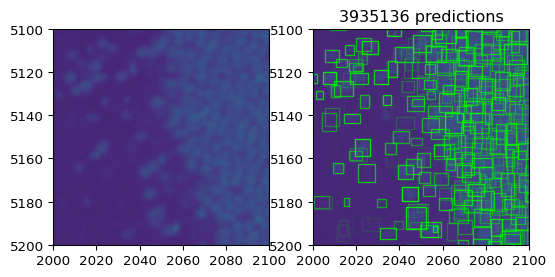

In [10]:
start = time.time()

# TODO: Adjust tiles to original input dimensions for visualization purposes?
addTiles = False
plotBbox = True
setBounds = True

img_idx = 1500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)

img = tifffile.imread(img_path)
img_up = preprocess(img)
if plotBbox:
    padded_img, tiles = img_to_tiles(img, lower_threshold_bg = 0.04, verbose=True)
else:
    padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04, verbose=True)
tile_dim = tiles[0]['img'].shape[0]

fig, axs = plt.subplots(1,2)

# if plotBbox:
#     for ax in axs:
#         ax.imshow(preprocess(img, upsample=False))
# else:
#     for ax in axs:
#         ax.imshow(padded_img)
for ax in axs:
    ax.imshow(preprocess(img, upsample=False))

out_fname = fname.split('.')[0] + '.npy'
out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
# out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}'
# ec = 'm' if 'home' in out_path else 'lime'
ec = 'lime'
out = torch.Tensor(np.load(out_path))

if addTiles:
    print('Adding tiles . . .')
    start = time.time()
    for tile in tiles:
        p = tile['p']
        bg = tile['bg']
        color = 'k' if bg else 'w'
        for ax in axs:
            rec = Rectangle(p[::-1],tile_dim,tile_dim, facecolor=color, edgecolor='k',alpha = 0.2)
            ax.add_patch(rec)
    print(f'Finished plotting tiles in {time.time()-start:.2f}s, {len(scores)} boxes present')

if plotBbox:
    print('Plotting bboxes . . .')
    # Filter out extra bboxes
    start = time.time()
    scores = out[:,:,-4].ravel()
    predicted_rectangles = bb_to_rec(out,fc='none',ec=ec,alpha=scores)
    axs[1].add_collection(predicted_rectangles)
    axs[1].set_title(f'{len(scores)} predictions')
    print(f'Finished plotting bboxes in {time.time()-start:.2f}s, {len(scores)} boxes present')

if setBounds:
    for ax in axs:
        ax.set_xlim([2000,2100])
        ax.set_ylim([5200,5100])

print(f'Finished entire image in {time.time()-start:.2f}s')

fig.canvas.draw()
# plt.savefig(f'/home/abenneck/Desktop/yolo_model/tiles_{img_idx}.png')

# Batch Mode

### Load + preprocess image, Initialize DataLoader

In [2]:
img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)
img = tifffile.imread(img_path)
img_up = preprocess(img) # Normalize, gamma correction, upsample by factor of 2
padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04)
pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2

nrow_t = int(np.max([tile['r_idx'] for tile in tiles])) + 1
ncol_t = int(np.max([tile['c_idx'] for tile in tiles])) + 1

ds = tileDataset(tiles)
dl = DataLoader(ds, batch_size = ncol_t, shuffle=False)

print(f'{nrow_t} x {ncol_t} tiles')

77 x 66 tiles


### Compare outputs in 'batch mode' and in 'tile mode'

In [3]:
model_path = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
model_path = os.path.join(model_path,'modelsave.pt')
dtype = torch.float32
net = Net()
net.load_state_dict(torch.load(model_path))
net.eval()

B = net.B
stride = net.stride

ds_factor = 8
tile_dim = 256
bbox_dim = 5
num_classes = 3
img_dim0 = padded_img.shape[0]
img_dim1 = padded_img.shape[1]
boundary_cond = (16,16)
ndim = 2

# # Apply model to 'nrow_t' several of tiles
# start_batch = time.time()
# recon_batch = np.zeros((bbox_dim*B+num_classes, int(img_dim0/ds_factor), int(img_dim1/ds_factor)))
# print('Starting batch mode . . .')
# for i_batch, batch in enumerate(dl):
#     imgs, meta_data = batch
#     if np.all(np.array(meta_data['bg'])):
#         print(f'Skipping batch {i_batch}/{nrow_t}')
#         continue
#     else:
#         start = time.time()
#         out = net(imgs)
#         for idx, elem in enumerate(out):
#             out_i = remove_bbox_in_overlap(elem[None].clone().detach(), B, stride, tile_dim, boundary_cond = boundary_cond)
#             p0 = meta_data['p'][0][idx]
#             p1 = meta_data['p'][1][idx]
#             recon_batch[:,int(p0/ds_factor):int((p0+tile_dim)/ds_factor), int(p1/ds_factor):int((p1+tile_dim)/ds_factor)] = out_i[0].detach().numpy()
#         print(f'Finished batch {i_batch}/{nrow_t} in {time.time()-start:.2f}s')
#         start = time.time()

# recon_batch = torch.tensor(recon_batch, dtype=torch.float32)
# recon_batch = postprocess(recon_batch, B, stride, pads, up_factor=2, verbose=True)
# print(f'Finished ALL batches in {time.time()-start_batch:.2f}s\n')


start_tile = time.time()
# Apply model to tiles + apply bbox edge filtering
print('Applying model to tiles . . .')
out = apply_model_to_tiles(tiles, model_path, padded_img.shape[0], padded_img.shape[1], verbose=True)

# Convert the raw model output into a more useful data structure
print('Postprocessing . . .')
pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
out = torch.tensor(out.clone().detach(), dtype=torch.float32)
recon_tile = postprocess(out, B, stride, pads, up_factor=2, verbose=True)
print(f'Finished ALL tiles in {time.time()-start_tile:.2f}s\n')

# Save the processed output
# out_fname = (img_path.split('/')[-1]).split('.')[0] + '.npy'
# out_path = f'/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/yolo_outputs_v03_32bit/{out_fname}'
# out_path = f'/home/abenneck/Desktop/yolo_model/{out_fname}'
# np.save(out_path, out)

# print(f'Saved the outputs for image {idx}/{len(os.listdir(img_dir))} in {time.time()-start_total:.2f}s\n')
start_total = time.time()


Applying model to tiles . . .
Finished tiles 0:1100/5082 in 3.34s
Finished tiles 1100:1300/5082 in 1.67s
Finished tiles 1300:1500/5082 in 1.71s
Finished tiles 1500:1600/5082 in 0.59s
Finished tiles 1600:1800/5082 in 1.94s
Finished tiles 1800:2000/5082 in 2.05s
Finished tiles 2000:2200/5082 in 2.10s
Finished tiles 2200:2400/5082 in 2.03s
Finished tiles 2400:2600/5082 in 1.92s
Finished tiles 2600:2800/5082 in 1.80s
Finished tiles 2800:3000/5082 in 1.61s
Finished tiles 3000:3200/5082 in 1.30s
Finished applying model to entire image in 22.45s with 1264/5082 (0.249) tiles marked as foreground
Postprocessing . . .


/tmp/ipykernel_1316541/4095638668.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out.clone().detach(), dtype=torch.float32)


Finished postprocessing in 0.24s
Finished ALL tiles in 22.76s



In [4]:
def tiles_to_orig(tiles, pads):
    tiles_out = []
    for tile in tiles:
        I = tile['img']
        p = tile['p']
        bg = tile['bg']
        r_idx = tile['r_idx']
        c_idx = tile['c_idx']

        # Shift the anchor point by the padded amount on each ax
        p -= pads

        # Reduce anchor point by upsampling factor
        p = np.asarray(p)/2
        
        new_tile = {'img':None, 'p':list(p), 'bg':bg, 'r_idx':r_idx, 'c_idx':c_idx}
        tiles_out.append(new_tile)

    return tiles_out

Adding tiles . . .
Finished plotting tiles in 4.87s
Plotting bboxes . . .
Finished plotting bboxes0 in 67.99s, 3935136 boxes present
Finished plotting bboxes1 in 119.07s, 3935136 boxes present
Finished entire image in 192.88s


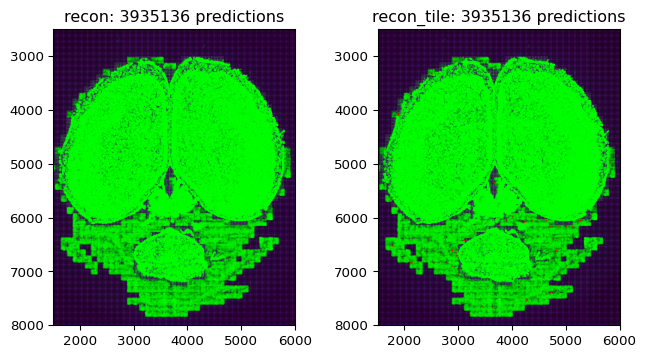

In [5]:
start_total = time.time()

plotBbox = True
addTiles = True
setBounds = True

img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)
img_plot = preprocess(img, upsample=False)
tiles_plot = tiles_to_orig(tiles, pads)

fig, ax = plt.subplots(1,2)
for ax_i in ax:
    ax_i.imshow(img_plot)

if addTiles:
    print('Adding tiles . . .')
    start = time.time()
    for tile in tiles_plot:
        p = tile['p']
        bg = tile['bg']
        color = 'k' if bg else 'w'
        rec = Rectangle(p[::-1],tile_dim/2,tile_dim/2, facecolor=color, edgecolor='k', linewidth=3, alpha = 0.1)
        ax[0].add_patch(rec)
        rec = Rectangle(p[::-1],tile_dim/2,tile_dim/2, facecolor=color, edgecolor='k', linewidth=3, alpha = 0.1)
        ax[1].add_patch(rec)
    print(f'Finished plotting tiles in {time.time()-start:.2f}s')

if plotBbox:
    print('Plotting bboxes . . .')
    start = time.time()
    # scores = recon_batch[:,:,-4].ravel()
    # predicted_rectangles = bb_to_rec(recon_batch,fc='none',ec='lime',alpha=scores)
    # ax[0].add_collection(predicted_rectangles)
    # ax[0].set_title(f'recon_batch: {len(scores)} predictions')
    # print(f'Finished plotting bboxes0 in {time.time()-start:.2f}s, {len(scores)} boxes present')
    scores = recon_tile[:,:,-4].ravel()
    predicted_rectangles = bb_to_rec(recon_tile,fc='none',ec='lime',alpha=scores)
    ax[0].add_collection(predicted_rectangles)
    ax[0].set_title(f'recon: {len(scores)} predictions')
    print(f'Finished plotting bboxes0 in {time.time()-start:.2f}s, {len(scores)} boxes present')
    
    start = time.time()
    scores = recon_tile[:,:,-4].ravel()
    ec = ['red' if s==0 else 'lime' for s in scores]
    scores = [1 if s==0 else s for s in scores]
    # ec = 'lime'
    predicted_rectangles = bb_to_rec(recon_tile,fc='none',ec=ec,alpha=scores)
    ax[1].add_collection(predicted_rectangles)
    ax[1].set_title(f'recon_tile: {len(scores)} predictions')
    print(f'Finished plotting bboxes1 in {time.time()-start:.2f}s, {len(scores)} boxes present')

if setBounds:
    for ax_i in ax:
        # ax_i.set_xlim([3900,4000])
        # ax_i.set_ylim([5100,5000])
        # ax_i.set_xlim([3950,4050])
        # ax_i.set_ylim([5070,4970])
        ax_i.set_xlim([1500,6000])
        ax_i.set_ylim([8000,2500])

print(f'Finished entire image in {time.time()-start_total:.2f}s')

fig.set_size_inches(8,4)
fig.canvas.draw()
# plt.savefig(f'/home/abenneck/Desktop/yolo_model/tiles_{img_idx}.png')

### Apply model to a single tile

In [104]:
def NMS_tile(I, B=2, iou_thresh = 0.9):
    """
    Note: bboxes are of the form [cx, cy, w, h] in relative units
    Note: I is a single tile and therefore has shape [13, 32, 32]
    """
    def bb_sort(t):
        return t[-1]

    def flat_idx_to_orig_idx(idx, flat_shape = 1024, orig_shape = (32,32)):
        return int(np.floor(idx/orig_shape[0])), int(idx%orig_shape[1])

    def IOU(bb0, bb1):
        l0 = bb0[0] - bb0[2]/2
        r0 = bb0[0] + bb0[2]/2
        t0 = bb0[1] - bb0[3]/2
        b0 = bb0[1] + bb0[3]/2

        l1 = bb1[0] - bb1[2]/2
        r1 = bb1[0] + bb1[2]/2
        t1 = bb1[1] - bb1[3]/2
        b1 = bb1[1] + bb1[3]/2

        intersection = (l1-r0) * (t1-b0)
        union = ((l0-r0) * (t0-b0)) + ((l1-r1) * (t1-b1)) - intersection
        return intersection/union
        
    I_out = np.ones(I.shape)*-np.inf

    # Sort bbs by confidene of first bb at each pixel
    conf_idx = sorted(list(enumerate(np.argsort(I[-4,:,:].clone().detach().numpy().ravel()))), key=bb_sort)
    I_flat = np.reshape(I.clone().detach().numpy(), (I.shape[0], I.shape[1]*I.shape[2]))
    num_bb = 5

    # Loop through bboxes in order of decresing confidence. 
    # Note that 'orig_idx' corresponds to the bbox located at I[:,orig_idx] after the last 2 axes of I have been flattened
    for flat_i, c_i in conf_idx:
        orig_xi, orig_yi = flat_idx_to_orig_idx(flat_i)
        
        # Determine which bb at (orig_xi, orig_yi) has a higher conf, then
        best_bb_idx = 0
        for b in range(B):
            if I_flat[4+best_bb_idx*num_bb, flat_i] < I_flat[4+b*num_bb, flat_i]:
                best_bb_idx = 1
        
        if I_flat[4+best_bb_idx*num_bb,flat_i] > 0: # If conf of bb isn't set to -inf, add it to the output
            I_out[:, orig_xi, orig_yi] = I_flat[:,flat_i]

            # Check IOU of current bb with all remaining bb
            for b in range(B):
                for flat_j, c_j in conf_idx[flat_i:]:
                    if IOU(I_flat[:(1+best_bb_idx)*5,flat_i], I_flat[:(1+b)*5,flat_j]) >= iou_thresh:
                        orig_xj, orig_yj = flat_idx_to_orig_idx(flat_j)
                        I_flat[4+b*num_bb,flat_j] = -np.inf
                        I_out[:, orig_xj, orig_yj] = I_flat[:,flat_j]

    return torch.Tensor(I_out[None])

def count_bb(out, B=2, num_bb=5):
    n = 0
    for b in range(B):
        n += len([bb for bb in np.reshape(out.clone().detach().numpy(), (out.shape[0]*out.shape[1],out.shape[2])) if bb[4+b*num_bb] > 0 ])
    return n

NMS took 0.2284s for 1 tile, and would add 1160.6100s for an img with 5082 tiles
Finished postprocessing in 0.00s
Finished postprocessing in 0.00s


/tmp/ipykernel_1316541/1109292400.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_NMS = torch.tensor(out_NMS[0].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1316541/1109292400.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out[0].clone().detach(), dtype=torch.float32)


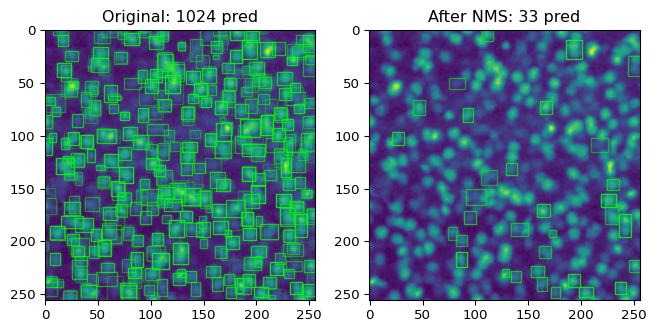

In [103]:
# Load the model
model_path = os.path.join('/home/abenneck/Desktop/yolo_outputs/models/nepochs_9854')
model_path = os.path.join(model_path,'modelsave.pt')
dtype = torch.float32
net = Net()
net.load_state_dict(torch.load(model_path))
net.eval()
B = net.B
stride = net.stride

# Load the image
img_idx = 500
img_dir = '/nafs/shattuck/RodentToolsData/ZW-DT-1-P56-1/Ex_488_Em_525_stitched'
fname = sorted(os.listdir(img_dir))[img_idx]
img_path = os.path.join(img_dir, fname)
img = tifffile.imread(img_path)
img_up = preprocess(img) # Normalize, gamma correction, upsample by factor of 2
padded_img, tiles = img_to_tiles(img_up, lower_threshold_bg = 0.04)
# pads = (np.array(padded_img.shape) - np.array(img_up.shape))/2
pads = (0,0)

# Apply the model to a tile
idx = 2000
tile = tiles[idx]
I = tile['img']
out = net((torch.tensor(I[None,None],dtype=dtype)))

start = time.time()
out_NMS = NMS_tile(out[0])
print(f'NMS took {time.time()-start:.4f}s for 1 tile, and would add {(time.time()-start)*len(tiles):.4f}s for an img with {len(tiles)} tiles')
out_NMS = torch.tensor(out_NMS[0].clone().detach(), dtype=torch.float32)
out_NMS = postprocess(out_NMS, B, stride, pads, verbose=True)

out = torch.tensor(out[0].clone().detach(), dtype=torch.float32)
out = postprocess(out, B, stride, pads, verbose=True)

# Plot the output
ec = 'lime'
scores = out[:,:,-4].detach().numpy()
predicted_rectangles = bb_to_rec(out,fc='none',ec=ec,alpha=scores)
scores = out_NMS[:,:,-4].detach().numpy()
predicted_rectangles_NMS = bb_to_rec(out_NMS,fc='none',ec=ec,alpha=scores)



fig, ax = plt.subplots(1,2)
ax[0].imshow(I)
ax[0].add_collection(predicted_rectangles)
ax[0].set_title(f'Original: {count_bb(out,B=1)} pred')
ax[1].imshow(I)
ax[1].add_collection(predicted_rectangles_NMS)
ax[1].set_title(f'After NMS: {count_bb(out_NMS,B=1)} pred')
fig.set_size_inches(8,4)

In [101]:
total = 0
for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        if out[i,j,4] > 0:
            total += 1

print(total)

3


In [24]:
torch.sigmoid(torch.Tensor([-np.inf, -1000, -100, -89, -88]))

tensor([0., 0., 0., 0.])

In [15]:

img_plot.shape

(8587, 7321)

Text(0.5, 1.0, 'bbox confidence')

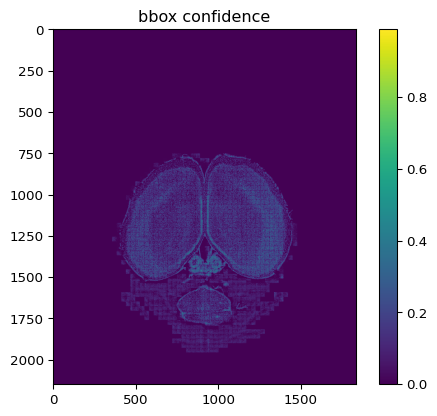

In [22]:
fig,ax = plt.subplots()
ax_ = ax.imshow(recon_tile[:,:,4])
fig.colorbar(ax_)
ax.set_title('bbox confidence')

### Deprecated Functions

In [ ]:
# Check if 'bbox' meets our criteria using 'boundary_cond'
def isValid(bbox, boundary_cond, tile_dim, verbose=False):
    """
    Check to see if 'bbox' should be removed based on 2 filtering criterion: (1) If the entire bbox lies in the upper left exclusion zone or (2) If part of the bbox lies in the lower right exclsuion zone. The upper left exclusion zone is defined as the 'boundary_cond[0]' pixels on the upper boundary and the 'boundary_cond[1]' pixels on the left boundary of the image. The loewr right exclusion zone is defined as the 'boundary_cond[0]' pixels on the lower boundary and the 'boundary_cond[1]' pixels on the right boundary of the image.

    Parameters:
    -----------
    bbox : np.array(float)
        A bounding box defined as [cx, cy, w, h] centered at (cx,cy) with a width of w and a height of h
    boundary_cond : np.array(int)
        The thickness of the exclusion zones along each axis
    tile_dim : int
        The size of the tiles used in the YOLO pipeline
    verbose : bool
        Default False; If True, print out when a bbox is kept or remove. Useful for debugging.

    Returns:
    --------
    boolean_value : bool
        False if the bbox satisfies either boundayr condition and True otherwise.
    
    """
    # boundary_cond for exclusion zone
    cx, cy, w, h = bbox
    left_bound = cx - w/2
    upper_bound = cy - h/2

    # if left_bound < boundary_cond[0] or upper_bound < boundary_cond[1]:
    if left_bound < boundary_cond[0] or upper_bound < boundary_cond[1]:
        # Part of bbox lies in the Upper/Left EXCLUSION zone
        if verbose:
            print(f'PART - Removed bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return False
    elif (left_bound >= (tile_dim - boundary_cond[0])) or (upper_bound >= (tile_dim - boundary_cond[1])):
        # Entire bbox lies in the Lower/Right EXCLUSION zone
        if verbose:
            print(f'ENTIRE - Removed bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return False
    else:
        if verbose:
            print(f'Kept bbox with bounds ({left_bound:.2f},{upper_bound:.2f})')
        return True

# Remove invalid bboxes from 'out' by setting the corresponding conf value in 'out' to -inf
def remove_bbox_in_overlap_DEP(out, B, stride, tile_dim, boundary_cond = [16,16]):
    """
    Remove bounding boxes that lie in the exclusion zone defined by 'boundary_cond' from the model output before appending to reconstruction.

    Parameters:
    -----------
    out : torch.Tensor of shape [13, tile_dim/stride, tile_im/stride]
        The output from the YOLO model after processing a tile_dim x tile_dim image.
    B : int
        the number of target classes used in the YOLO model
    stride : int
        The nmuber of pixels the kernel moves during each step of the YOLO model
    tile_dim : int
        The dimensions of a tile extracted from the original image
    boundary_cond : np.array(int)
        The thickness of the exclusion zones along each axis

    Returns:
    --------
    out : torch.Tensor of shape [13, tile_dim/stride, tile_im/stride]
        The original output from the model, but now bboxes that don't meet the filtering criterion have a confidence of -inf.
    """

    # Get the positions of the grid cells
    x = torch.arange(out.shape[-1])*stride + (stride-1)/2
    y = torch.arange(out.shape[-2])*stride + (stride-1)/2
    YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)

    # Convert bbox0 data to dimensions that are relative to the original input
    outB0 = out[:,:5]
    x0 = (torch.sigmoid(outB0[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y0 = (torch.sigmoid(outB0[:,1])-0.5)*stride + YX[0]
    w0 = torch.exp(outB0[:,2])*stride
    h0 = torch.exp(outB0[:,3])*stride
    x0 = x0 - w0/2
    y0 = y0 - h0/2

    # Convert bbox1 data to dimensions that are relative to the original input
    outB1 = out[:,5:10]    
    x1 = (torch.sigmoid(outB1[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
    y1 = (torch.sigmoid(outB1[:,1])-0.5)*stride + YX[0]
    w1 = torch.exp(outB1[:,2])*stride
    h1 = torch.exp(outB1[:,3])*stride
    x1 = x1 - w1/2
    y1 = y1 - h1/2

    # Modify model output by setting conf of invalid bboxes to -inf
    numKeep = 0
    numRemove = 0
    for r in range(np.shape(out)[2]):
        for c in range(np.shape(out)[3]):
            line = out[0,:,r,c]

            # Extract bbox0 info for grid cell (r,c)
            x_ = x0[:,r,c].detach().numpy().item()
            y_ = y0[:,r,c].detach().numpy().item()
            w_ = w0[:,r,c].detach().numpy().item()
            h_ = h0[:,r,c].detach().numpy().item()
            bb0 = np.asarray([x_, y_, w_, h_])

            # print(f'(0,{r},{c}) - {bb0} : ', end='')
            if isValid(bb0, boundary_cond, tile_dim):
                numKeep += 1
            else:
                out[:,4,r,c] = -np.inf
                numRemove += 1

            # Extract bbox1 info for grid cell (r,c)
            x_ = x1[:,r,c].detach().numpy().item()
            y_ = y1[:,r,c].detach().numpy().item()
            w_ = w1[:,r,c].detach().numpy().item()
            h_ = h1[:,r,c].detach().numpy().item()
            bb1 = np.asarray([x_, y_, w_, h_])

            # print(f'(1,{r},{c}) - {bb1} : ', end='')
            if isValid(bb1, boundary_cond, tile_dim):
                numKeep += 1
            else:
                out[:,9,r,c] = -np.inf
                numRemove += 1

    return torch.Tensor(out)